# Star Classification


## Setup and Intro

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp_stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

data = pd.read_csv('data/star_classification.csv')
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

# Data Description:
1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

**Do we need to keep all of these? No...**
- y (target) = class
- x (features) = alpha, delta, u, g, r, i, z, redshift

In [3]:
data['class'].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

## Preparation and Functions

In [4]:
def normalisation(col):
    col_min = col.min()
    col_max = col.max()

    new_col = (col - col_min) / (col_max-col_min)
    return new_col

stellar_calss_dict = {
    'GALAXY' : 0
    , 'STAR' : 1
    , 'QSO' : 2
}

In [5]:
features = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']
data[features].describe()   

,alpha,delta,u,g,r,i,z,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661
std,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971
25%,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517
50%,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173
75%,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


- From the table above we can tell that the chosen features are all continuous variables.
- So we don't need to carry out any one-hot categorical encoding.
- **However, normalising the columns will be very useful!**

In [6]:
random_state = 17
data['class'] = data['class'].map(stellar_calss_dict)
X_train, X_val, y_train, y_val = train_test_split(data[features], data['class'], train_size = 0.6, random_state=random_state)

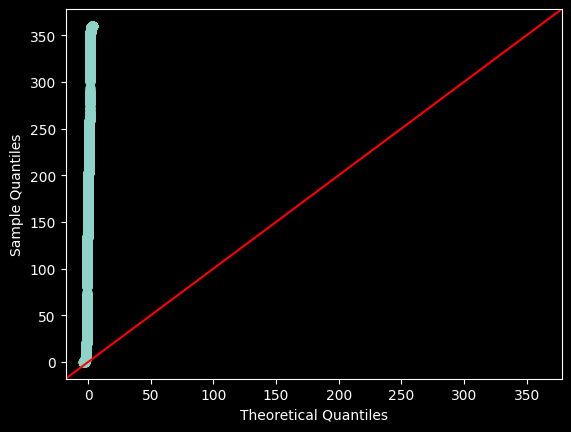

In [7]:
fig = sm.qqplot(X_train['alpha'], line='45')

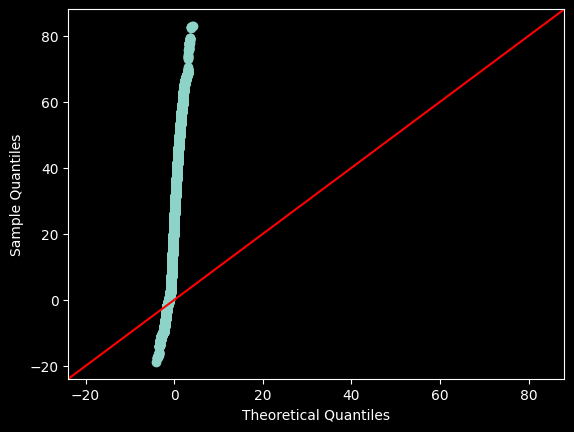

In [8]:
fig = sm.qqplot(X_train['delta'], line='45')

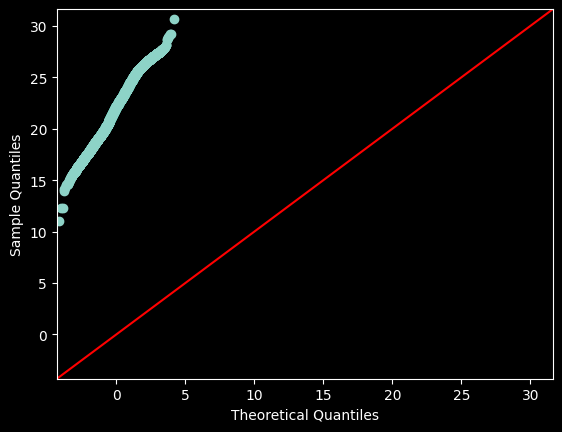

In [9]:
fig = sm.qqplot(X_train['u'], line='45')

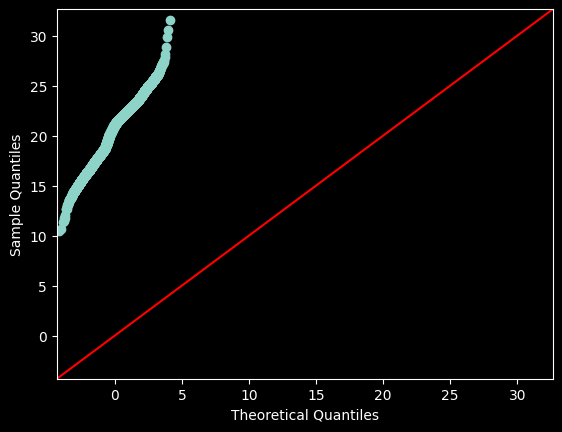

In [10]:
fig = sm.qqplot(X_train['g'], line='45')

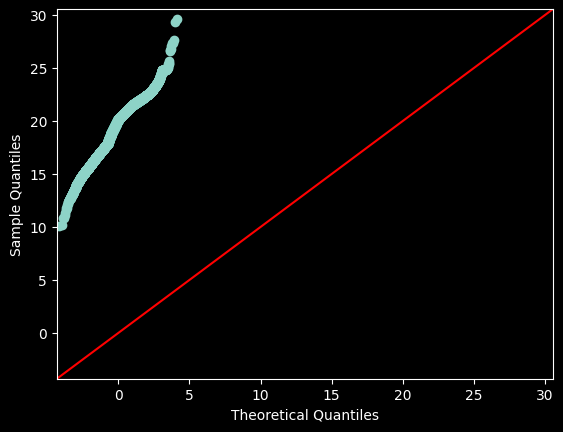

In [11]:
fig = sm.qqplot(X_train['r'], line='45')

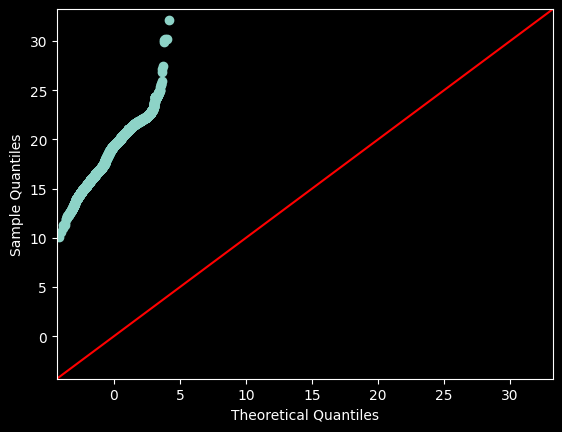

In [12]:
fig = sm.qqplot(X_train['i'], line='45')

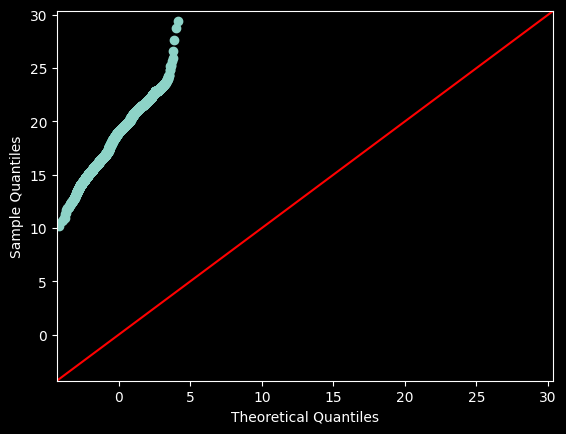

In [13]:
fig = sm.qqplot(X_train['z'], line='45')

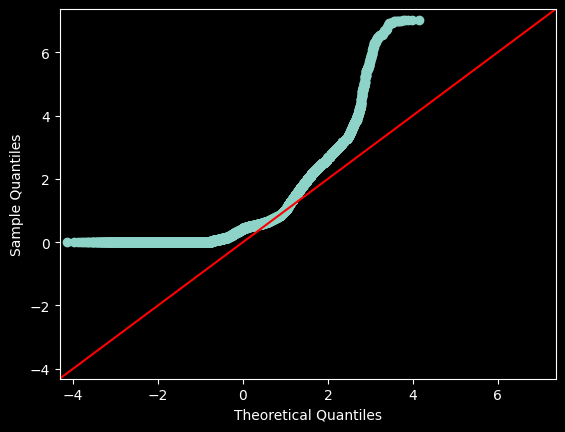

In [14]:
fig = sm.qqplot(X_train['redshift'], line='45')

In [15]:
X_train_norm = X_train.apply(normalisation, axis=0)
X_train_norm.describe()

,alpha,delta,u,g,r,i,z,redshift
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.493437,0.421750,0.563822,0.479905,0.491170,0.408926,0.446036,0.083238
std,0.268676,0.193252,0.114538,0.096714,0.095315,0.079814,0.092406,0.104362
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.353570,0.235056,0.475818,0.401139,0.413796,0.347770,0.377885,0.008836
50%,0.502556,0.416926,0.568924,0.502267,0.515580,0.423274,0.458267,0.061382
75%,0.649993,0.576452,0.645408,0.550589,0.563114,0.468428,0.505984,0.101368
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
X_val_norm = X_val.apply(normalisation, axis=0)
X_val_norm.describe()

,alpha,delta,u,g,r,i,z,redshift
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.493351,0.415801,0.998908,0.999313,0.551556,0.470733,0.999030,0.083413
std,0.267158,0.195326,0.005000,0.005001,0.103819,0.085729,0.004998,0.103704
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.355120,0.226836,0.998761,0.999171,0.466784,0.404386,0.998924,0.009050
50%,0.502419,0.410949,0.998943,0.999384,0.578753,0.486650,0.999079,0.061854
75%,0.649216,0.573261,0.999093,0.999487,0.629722,0.534841,0.999171,0.101626
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Model Training - Attempt 1

In [17]:
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.1, verbosity=1, random_state=random_state, early_stopping_rounds=10)
xgb_model.fit(X_train_norm, y_train, eval_set = [(X_val_norm, y_val)])

[0]	validation_0-mlogloss:0.98700
[1]	validation_0-mlogloss:0.89254
[2]	validation_0-mlogloss:0.81240
[3]	validation_0-mlogloss:0.74329
[4]	validation_0-mlogloss:0.68505
[5]	validation_0-mlogloss:0.63257
[6]	validation_0-mlogloss:0.58956
[7]	validation_0-mlogloss:0.55480
[8]	validation_0-mlogloss:0.52014
[9]	validation_0-mlogloss:0.49277
[10]	validation_0-mlogloss:0.46713
[11]	validation_0-mlogloss:0.44611
[12]	validation_0-mlogloss:0.42634
[13]	validation_0-mlogloss:0.41021
[14]	validation_0-mlogloss:0.39925
[15]	validation_0-mlogloss:0.38932
[16]	validation_0-mlogloss:0.38023
[17]	validation_0-mlogloss:0.37333
[18]	validation_0-mlogloss:0.36574
[19]	validation_0-mlogloss:0.35885
[20]	validation_0-mlogloss:0.35297
[21]	validation_0-mlogloss:0.34856
[22]	validation_0-mlogloss:0.34572
[23]	validation_0-mlogloss:0.34364
[24]	validation_0-mlogloss:0.33856
[25]	validation_0-mlogloss:0.33266
[26]	validation_0-mlogloss:0.32625
[27]	validation_0-mlogloss:0.32318
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [18]:
print(f"{xgb_model.best_iteration}, {xgb_model.best_score}")

100, 0.25709532928858386


In [19]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train_norm),y_train):.4f}")

Metrics train:
	Accuracy score: 0.9833


In [20]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val_norm),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9386


## Data Visualisation

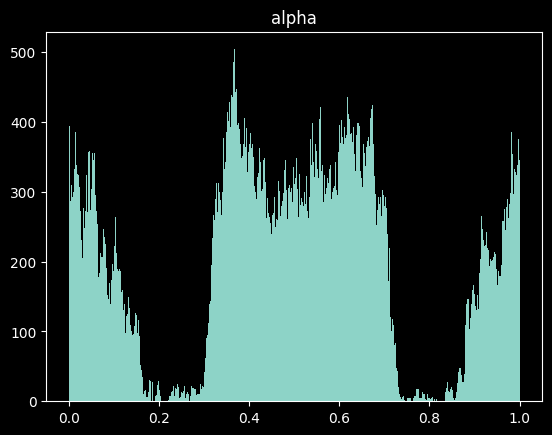

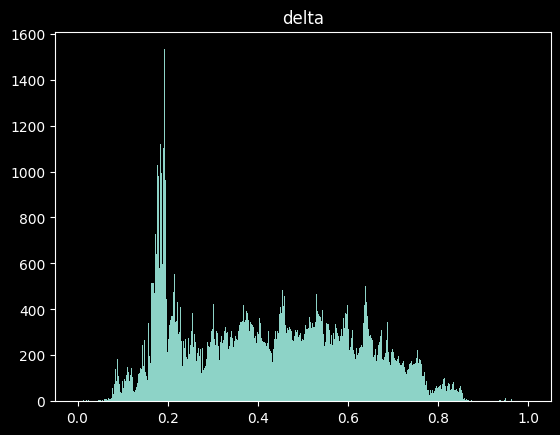

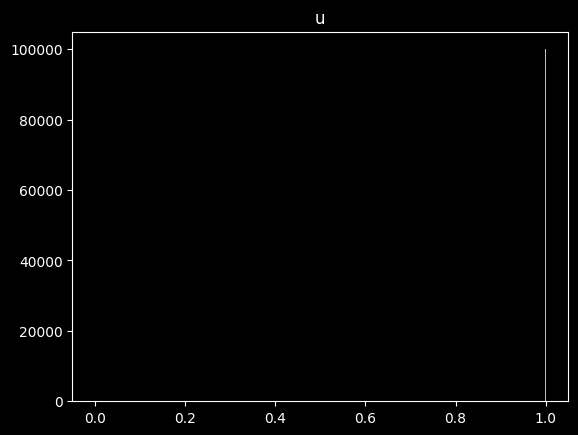

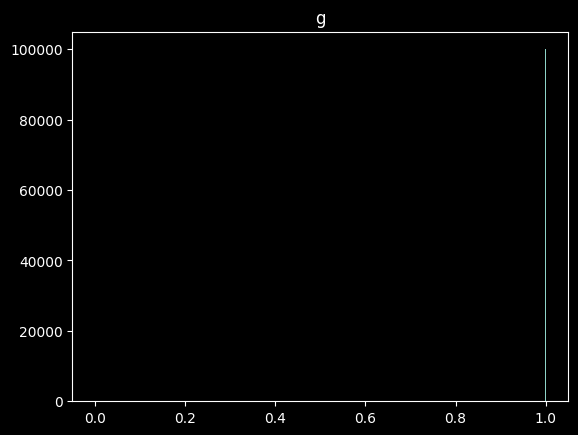

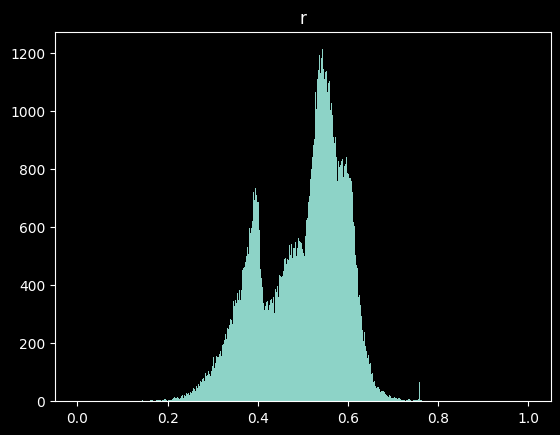

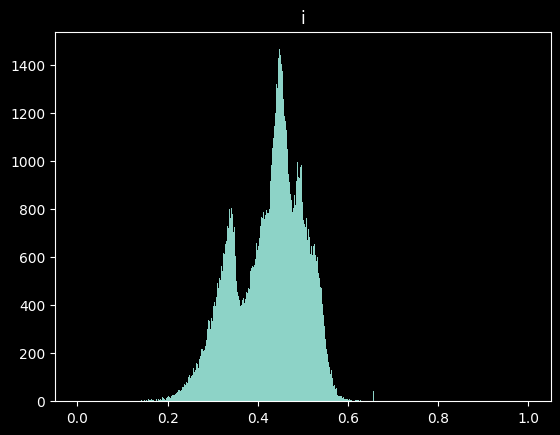

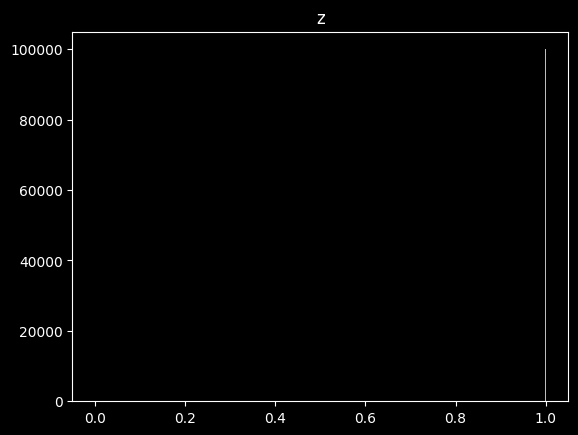

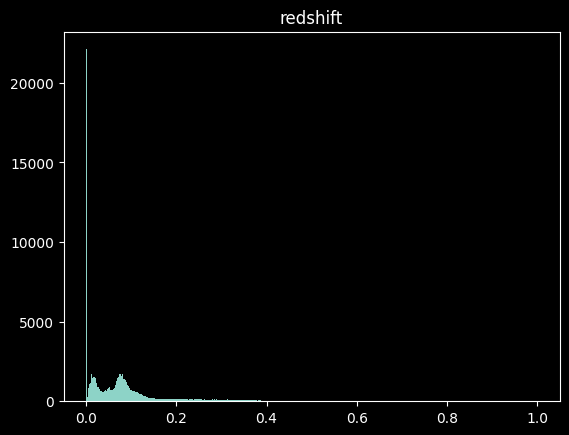

In [21]:
data_normalised = data[features].apply(normalisation, axis=0)

for feature in features:
    plt.hist(data_normalised[feature], bins=500)
    plt.title(feature)
    plt.show()

In [22]:
data_normalised['redshift'].describe()

count    100000.000000
mean          0.083551
std           0.104071
min           0.000000
25%           0.009185
50%           0.061833
75%           0.101710
max           1.000000
Name: redshift, dtype: float64

In [30]:
gen_values = np.linspace(np.min(data_normalised['i']), np.max(data_normalised['i']), 10000)

def fit_norm_to_data(data_col, gen_values):
    mean = np.mean(data_col)
    std = np.std(data_col)

    pdf_norm = sp_stats.norm.pdf(gen_values, mean, std)
    
    plt.hist(data_col, bins=100, density=True, alpha=0.5)
    plt.plot(gen_values, pdf_norm);

def fit_skew_norm_to_data(data_col, gen_values):    
    p_skewnorm = sp_stats.skewnorm.fit(data_normalised['i'])
    pdf_skewnorm = sp_stats.skewnorm.pdf(gen_values, *p_skewnorm)

    plt.hist(data_col, bins=100, density=True, alpha=0.5)
    plt.plot(gen_values, pdf_skewnorm);

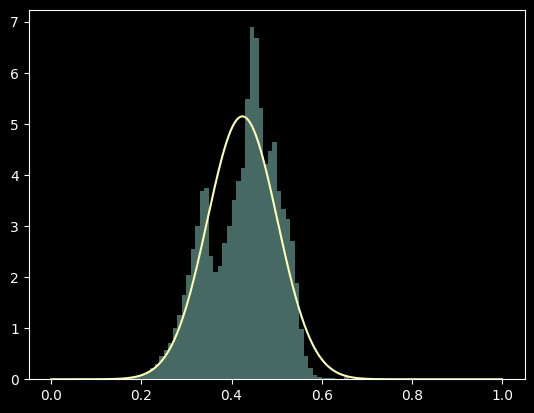

In [31]:
fit_norm_to_data(data_normalised['i'], gen_values=gen_values)

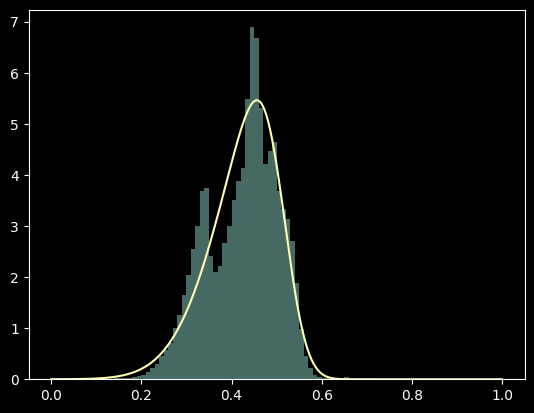

In [33]:
fit_skew_norm_to_data(data_normalised['i'], gen_values)